In [ ]:
import re
import pandas as pd
import numpy as np
import pyvista as pv

In [16]:
# Import CSV (lidar_dist_meters, lidar_angle_deg, servo_angle_deg)

df = pd.read_csv('/Users/anxiankhoo/Documents/lidar/lidar.csv')
df

,lidar_dist_meters,lidar_angle_deg,servo_angle_deg
0,360,100,0
1,359,99,0


In [ ]:
# Convert into cartesian coordinates and save to new CSV

# Convert angles from degrees to radians
phi = np.deg2rad(df["lidar_angle_deg"])     # vertical plane angle
theta = np.deg2rad(df["servo_angle_deg"])   # horizontal plane angle
r = df["lidar_dist_meters"] 

# Convert to cartesian coordinates
x = r * np.cos(phi) * np.cos(theta)
y = r * np.cos(phi) * np.sin(theta)
z = r * np.sin(phi) 

# Store in new dataframe
cartesian_df = pd.DataFrame({
    "x": x,
    "y": y,
    "z": z 
})

# Save to CSV 
cartesian_df.to_csv("lidar_cartesian.csv", index=False)
print(f"Saved to CSV")

/Users/anxiankhoo/Documents/lidar/.venv/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


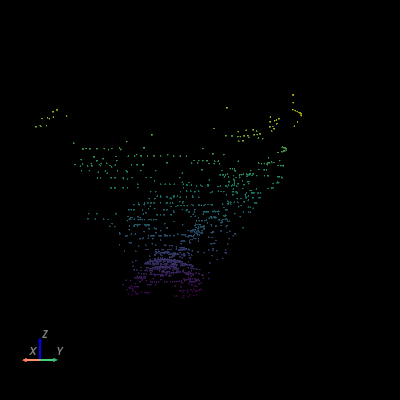

In [ ]:
# Optional: Make point cloud (tested with sample CSV)

cartesian_df = pd.read_csv("/Users/anxiankhoo/Documents/lidar/spherical-data-livingRoom.csv")  # Replace with your filename if different

# Extract point coordinates as a NumPy array
points = cartesian_df[["x", "y", "z"]].to_numpy()

# Create a PyVista point cloud
point_cloud = pv.PolyData(points)

# Basic plot
pl = pv.Plotter()
pl.add_mesh(point_cloud, 
            render_points_as_spheres = True,
            scalars = points[:, 2],
            point_size = 2,
            show_scalar_bar = False,
            )
camera = pv.Camera()
pl.camera = camera
pl.camera_position = 'yz'
pl.window_size = [400, 400]
pl.camera.azimuth = 45
pl.add_axes()
pl.show()

In [27]:
# Tracking change in floor points

# Imports
from datetime import datetime
import os 

# Definitions 
alert_threshold = -20 # Trigger alert if >20% decrease in floor space

# Detecting points on floor level (lowest 2 cm) 
min_z = cartesian_df["z"].min()
floor_band = 0.02  # 2 cm band
floor_points = df[cartesian_df["z"] <= (min_z + floor_band)]

# Count number of floor points 
floor_count = len(floor_points)

# Prepare entry with today's date 
date = datetime.today().strftime("%Y-%m-%d")
entry = pd.DataFrame({"date": [date], "floor_point_count": [floor_count]})

# Load into CSV 
summary_path = "floor_point_counts.csv"
if os.path.exists(summary_path):
    summary_df = pd.read_csv(summary_path)
    # Prevent duplicate entry for the same day
    summary_df = summary_df[summary_df["date"] != date]
    summary_df = pd.concat([summary_df, entry], ignore_index=True)
    # Sort by date
    summary_df["date"] = pd.to_datetime(summary_df["date"]) 
    summary_df = summary_df.sort_values("date").reset_index(drop=True)
else:
    summary_df = entry
    summary_df["date"] = pd.to_datetime(summary_df["date"]) 

# Compute percentage change and flag alert if needed 
summary_df["pct_change"] = summary_df["floor_point_count"].pct_change() * 100
summary_df["alert"] = summary_df["pct_change"].abs() < alert_threshold

# Save updated summary
summary_df.to_csv(summary_path, index=False)
print(f"Saved {floor_count} floor points to {summary_path}")

Saved 2 floor points to floor_point_counts.csv


/var/folders/_s/b8f0xfm57kz1g5n5_lr6jb3h0000gn/T/ipykernel_57743/3645873358.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  floor_points = df[cartesian_df["z"] <= (min_z + floor_band)]
